micrograd from scratch *(part 1)*
======================
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/2023_llnl-dsc%2F2023_llnl-dsc-tutorials/HEAD?labpath=micrograd_from_scratch%2Fmgfs_p1.ipynb)

CC-BY-SA 4.0 - Lorenzo A. Booth

This is a notebook that follows the Andrej Karpathy's video: 
[The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0).

This is provided as an accompanyment to the seminar given at the 2023 Data Science Challenge at LLNL. Working out exercises by hand is a stronger way of learning something, rather than just pressing play a notebook you found on the internet, so I encourage you to check out Dr. Karpathy's [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html) series and follow on re-implementing the videos in a notebook of your own.


## Imports



In [38]:
import math, random, time
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import widgets, interact

## Introduction



### Calculus refresher (derivative)



First let's define a function:
\begin{equation}
f(x) = 3 x^2 + 5
\end{equation}



In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

We see how it evaluates. For example, $ f(3) = 20 $.



In [ ]:
f(3.0)

Now let's evaluate this function over [-5,5] so that we can plot it.



In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now, let's consider the slope of the function in a sort-of-[*(ε, δ)*](https://en.wikipedia.org/w/index.php?title=Limit_of_a_function&oldid=1157938886#(%CE%B5,_%CE%B4)-definition_of_limit) sense, where
we examine the slope for increasingly small values of a step `h` (aka the *δ*)
along the domain of the function (x-axis).



In [ ]:
x = 3

In [ ]:
h = 0.001
f(x + h)

In [ ]:
f(x + h) - f(x)

And this is the approximation for our slope.



In [ ]:
(f(x + h) - f(x))/h

Note how this value changes for increasingly small values of `h`.



In [ ]:
h = 0.000001
(f(x + h) - f(x))/h

You can play around with this using the widget below (*jupyter widgets are
not compatible with all notebook servers, so this might not be interactive
for you*).

In [ ]:
interact(lambda h: (f(x + h) - f(x))/h, 
         h=widgets.FloatLogSlider(value=0.1, base=10, 
                                min=-10, max=0, step=1))

### Calculus refresher (partial derivative)



In [ ]:
a = 2.0
b = -3.0
c = 10.0
y = a * b + c
y

Lets consider the derivative of y with respect to a, b, and c.



In [ ]:
a = 2.0
b = -3.0
c = 10.0
h = 0.001
d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope (dy/da)', (d2 - d1)/h)

In [ ]:
a = 2.0
b = -3.0
c = 10.0
h = 0.001
d1 = a * b + c
b += h    # <--------------
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope (dy/db)', (d2 - d1)/h)

In [ ]:
a = 2.0
b = -3.0
c = 10.0
h = 0.001
d1 = a * b + c
c += h    # <--------------
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope (dy/dc)', (d2 - d1)/h)

Just to check in, we now have reviewed how to calculate of the slope of some multivariate function <i><u>with respect to</u></i> each of the constituent variables by means of the partial derivatives.

## Backprop from scratch



### Basic scalar operations



Now that we have an intuition for what derivatives are telling us, let's move on
to neural networks. Thinking back to the [3b1b](https://www.youtube.com/watch?v=aircAruvnKk) video, one can imagine how neural
networks will end up as massive mathematical expressions (even though the
individual operations are simple).

Let's create some data structures to maintain these expressions. When we use libraries like pyTorch, the library provides these functions and classes for us. Here, we're going to make our own now. We'll start with a structure that stores a single scalar value and reproduces it (aka prints to console when called).

In Python:
- `__init__` is run when whenever we create an object. Here it's just taking in `data` and storing it in `self.data`
- `__repr__` is run when we call `str()` on an object. It returns the **repr**esentation of the object, which in our case is just `print`ing the value to
the console.
storing it in `self.data`



In [16]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"


a = Value(2.0)
b = Value(-3.0)
print(a)
print(a,b)

Value(data=2.0)
Value(data=2.0) Value(data=-3.0)


Now we want to be able to add two `Value`'s.

In [17]:
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

Oops, we get an error because Python currently doesn't know how
to add two of our homemade `Value` objects, so we have to create that functionality. In Python:
- `__add__` is run when we use the `+` operator

In [2]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):     # <--------------
        out = Value(self.data + other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

Let's create the functionality for multiplication.



In [3]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):     # <--------------
        out = Value(self.data + other.data)
        return out

    def __mul__(self,other):     # <--------------
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print(a * b)
print(d)

Value(data=-6.0)
Value(data=4.0)


Under the hood, the functions that we defined are called each time we use the respective operators. Note how these two expressions below are equivalent.



In [4]:
print((a.__mul__(b)).__add__(c))
print((a*b)+c)

Value(data=4.0)
Value(data=4.0)


### Maintain connections



We want to maintain the connections between things in our neural *network*. We need to create this "connective tissue" by keeping track of *pointers* regarding which values create other values.

Here, we will keep track of the "children" of an operation (`_children`). That is, when we perform an addition, we want to get the result of the addition *and* we want to get the values that went into the operation.

In [5]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)     # <--------------

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other))
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print(d)
print(d._prev)

Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}


Wait there were 3 operations here right? Why are we only seeing two values in `_prev`? Hold tight, we will answer that after the next block.

Okay. We now can keep track of the value of an operation and the "children" that went into the operation. We now want to know "what was the operation that created this value?" We will do this by tacking on an element (here, a string) that represents the operation (`_op`).

In [6]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)     # <--------------
        self._op = _op                  # <--------------

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print(d)
print(d._prev)
print(d._op)

Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}
+


Why does `d._op` return `+`? Well, it's related to why `_prev` shows two values.

Remember that according to Python's order of operations, `d` was constructed out of the addition of two values (recall: `a.__mul__(b).__add__(c)`).

### Visualizing the expressions



It would be nice to be able to visualize the connections between operations that
we are keeping track of. Here is some code that lets us do that. The code might
look harry&#x2013;don't worry about how it works (fn:1), but let's take a look at what it
produces:



In [7]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def get_variable_name(variable):
    globals_dict = globals()
    out =  [var_name for var_name in globals_dict if globals_dict[var_name] is variable]
    try:
        return out[0]
    except IndexError:
        return "~"

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left-to-right
    #dot.attr(bgcolor = "gray")

    nodes, edges = trace(root)
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') for it
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (get_variable_name(n), n.data),
                 shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

The code uses the API of [Graphviz](https://en.wikipedia.org/wiki/Graphviz) to build out a diagram according to some
inputs that we give it. Here, it shows the computation graph &#x2013; the operations
that went into computing `d`, reproduced below:



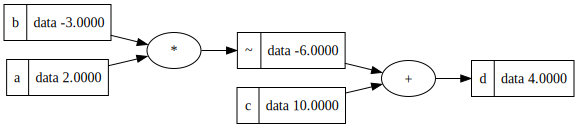

In [8]:
d = a * b + c
draw_dot(d)

Let's make an expression that is "one layer deeper":

\begin{align*}
d &= (ab + c) \\
L &= d \times e \\
L &= (ab + c) \times e
\end{align*}

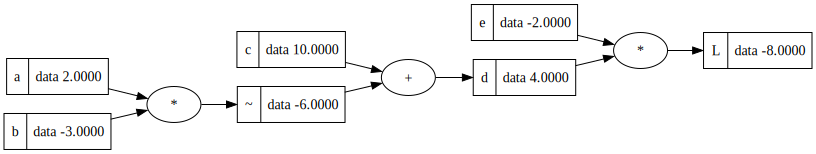

In [9]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
e = Value(-2.0)

L = d * e
draw_dot(L)

### The concept of a "forward pass"

Let's recap what we have done so far:

-   We're able to build out mathematical expressions on scalar values (so far,
    only using `+` and `*`)
    -   Where intermediate and output values are all scalar-valued
-   We can perform a "forward pass" and create a mathematical expression with a
    single value.

In other words, the "forward pass" is the calculation process by which input
data produce an output. The graph of operations performed in this forward pass
is visualized above.



### Back-propagation

Next, we would like to perform back-propagation. In back-propagation, we start
at the end (in the above case, starting at `L`) and calculate the gradient along all
of these intermediate values. What this amounts to is computing the derivative
of every single node with respect to `L`.

Let's think about how that would play out:

-   The derivative of `x` with respect to `L`

In the neural network setting, we are very interested in the derivatives of this
loss function (fn:2) `L` with respect to the weights of the
neural network. Here, we just have these variables `a,b,c,d,e`, but eventually
they will represent the weights of the neural net. Recall from the videos: we
want to tune the weights by training, and in order to do that we need to see how
they affect the loss function. This allows us to know what direction we need to
adjust the weights.



### Maintain derivatives (grad)

#### defining `grad`

Now, we would like to keep track of the derivatives of `L` with respect to each
`Value`. We will call this variable `grad`.



In [23]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0   
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

Some things to note:

-   At the beninging, `self.grad = 0`, which translates to "no effect". We start
    with this premise/assumption, which means "changing this variable will not
    change the loss function".
-   `grad` represents the derivative **of the output** (`L`) with respect to each value.

Let's also change `draw_dot()` so that we can print the derivatives (`grad`) and the name
of the variable.



In [24]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left-to-right
    #dot.attr(bgcolor = "gray")

    nodes, edges = trace(root)
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') for it
        dot.node(name=str(id(n)),
                 label = "{ %s | data %.4f | grad %.4f }" % (get_variable_name(n), n.data, n.grad),
                 shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Note: Now, we're denoting the *intermediate operation* of `a*b` as `ab`, just for clarity.

And just to keep track of things, we're going to put the callculation of L in a function called `lol`. Recall:
\begin{align*}
d &= (ab + c) \\
L &= d \times e \\
L &= (ab + c) \times e
\end{align*}

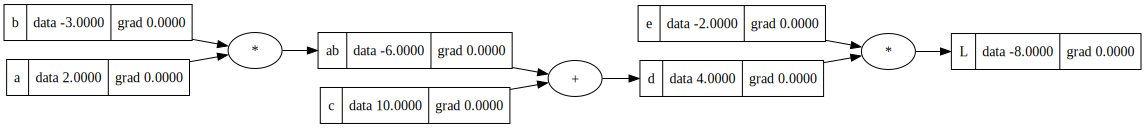

In [26]:

    a = Value(2.0)
    b = Value(-3.0)
    ab = a*b
    c = Value(10.0)
    d = ab + c
    e = Value(-2.0)

    L = d * e

draw_dot(L)

#### maintaining derivatives (the long way)



Let's try to fill in these derivatives manually (the long way).

Think back to our calculus example at the top of thise notebook:
how does L change if we increment `a` by some small delta `h`? (fn:3)



In [27]:
def lola():
    """calculate the slope of L along a plus some \delta h """
    h = 0.0001

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L1 = L.data

    a = Value(2.0+h)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L2 = L.data

    print((L2-L1)/h)
lola()

6.000000000021544


Let's perform backpropagation by hand, starting at L.

The derivative of `L` with respect to `L`. aka: "If I change L by a tiny amount
`h`, how much does `L` change? Well, it changes by `h`. Normalized by `h` we
get `h/h = 1`. We can think of this as the base case.



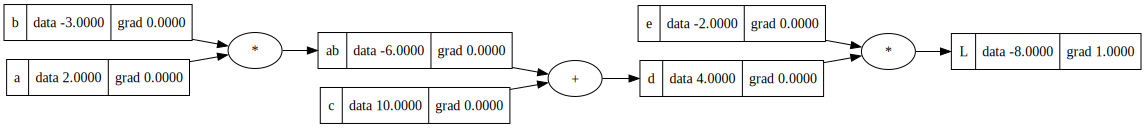

In [28]:
L.grad = 1
draw_dot(L)

Next, starting at the children of `L` which are: `d` and `e`. Let's do `d`
first. We know: `L = d * e`. We want: `dL/dd = ?`

\begin{align*}
L &= d \times e \\
\frac{\partial L}{\partial d} &= e
\end{align*}

If you don't believe me, you can consider a proof based on the definition of
the limit $\frac{f(x + h) - f(x)}{h}$:

\begin{align}
\frac{(d + h) \times e - d \times e}{h} \\
\frac{(d \times e + h \times e - d \times e)}{h} \\
\frac{(h \times e)}{h} \\
e
\end{align}

Symmetrically:

\begin{align*}
L &= d \times e \\
\frac{\partial L}{\partial e} &= d
\end{align*}

So, `e.grad` is just the value of `d` (`=4`) and `d.grad` is just the value of
`e` (`=-2`).



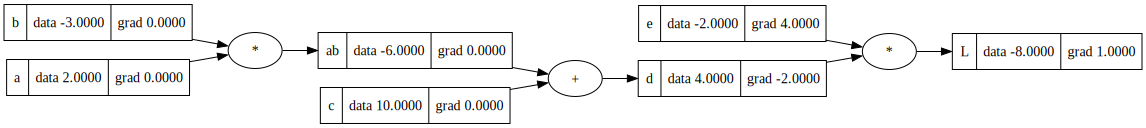

In [29]:
e.grad = 4.0
d.grad = -2.0
draw_dot(L)

Let's double check for the value of `e`, with our little toy environment from
before. Considering the effect of a small delta `h` on `e`:



In [30]:
def lole():
    """calculate the slope of L along a plus some \delta h """
    h = 0.0001

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L1 = L.data

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0+h)
    L = d * e

    L2 = L.data

    print((L2-L1)/h)
lole()

3.9999999999995595


Believable now?

The result is 4 (minus some rounding error), but in the limit we will
approach 4. We can verify the same thing with `d`.

Now we get to the crux of backpropagation, considering the gradient at this
important node `c`.

**If you understand the gradient at this node then you will
understand all of backpropagation and of the basic training of all neural nets.**

Let's do `c`. We want: `dL/dc = ?` How are we going to get that? Well, we
already know `dL/dd`, and we can calculate `dd/dc`. Surely there's some way to
combine that? Phrased differently: we want to find how sensitive `L` is by
wiggling `c` *through* `d`.

Let's start with $\frac{\partial d}{\partial c}$.
Remembering calculus, we can find it as follows:

\begin{align*}
d &= ab + c \\
\frac{\partial d}{\partial c} &= 1
\end{align*}

If you don't believe me, you can consider a proof based on the definition of
the limit $\frac{f(x + h) - f(x)}{h}$:

\begin{align}
\frac{(c + h) + ab - (c + ab)}{h} \\
\frac{(c + h + ab - c - ab)}{h} \\
\frac{(h)}{h} \\
1
\end{align}

Symmetrically:

\begin{align*}
d &= c + ab \\
\frac{\partial d}{\partial ab} &= 1
\end{align*}

#### the chain rule

To put this all together to find $\frac{\partial L}{\partial c}$, we use the
[Chain rule](https://en.wikipedia.org/wiki/Chain_rule) from calculus. Via *The Wiki*:
> If a variable *z* depends on the variable *y*, which itself depends on the
> variable *x*, then *z* depends on *x* as well, via the intermediate variable
> *y*.$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$

In this case, our intermediate variable between *c* and *L* is *d*. Recall:
\begin{align*}
d &= (ab + c) \\
L &= d \times e \\
L &= (ab + c) \times e
\end{align*}

This translates into a very simple recipe for us:
\begin{align*}
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} \\
\frac{\partial L}{\partial (ab)} &= \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial ab}
\end{align*}



So, let's plug in the partial derivatives that we just calculated.

In [31]:
c.grad = -2.0    # = d.data
ab.grad = -2.0   # = d.data
draw_dot(L)

As an aside, notice now the partial derivative calculation is so neat when the operator is addition.

In the parlance of neural networks:
> You can think of a "plus node" as just distributing the gradient of the parent
> to its children without modifying it.

Let's double check for the value of `c`, with our little toy environment from
before. Considering the effect of a small delta `h` on `c`:



In [32]:
def lolc():
    h = 0.0001

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L1 = L.data

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0+h)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L2 = L.data

    print((L2-L1)/h)
lolc()

-1.9999999999953388


Now we will perform one more application of the chain rule to find:
\begin{align*}
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial ab} \cdot \frac{\partial ab}{\partial a} \\
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial ab} \cdot \frac{\partial ab}{\partial b}
\end{align*}

Remembering calculus, we can arrive at:

\begin{align*}
ab &= a * b \\
\frac{\partial ab}{\partial a} &= b \\ 
\frac{\partial ab}{\partial b} &= a
\end{align*}



In [33]:
a.grad = -2.0 * -3.0   # = grad.ab * b.data
b.grad = -2.0 * 2.0   # = grad.ab * a.data
draw_dot(L)

Those are our claims, let's verify:



In [34]:
def lola():
    h = 0.0001

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L1 = L.data

    a = Value(2.0+h)
    b = Value(-3.0)
    c = Value(10.0)
    d = a * b + c
    e = Value(-2.0)
    L = d * e

    L2 = L.data

    print((L2-L1)/h)
lola()

6.000000000021544


All we've done is iterate by each node and *locally apply the chain rule*.

Because we have **pointers to the local derivatives** it makes it easy and
straightforward to *recursively apply the chain rule backwards through the
computational graph*!!!



### Optimizing for dummies



Let's see the power of back-propagation in action. Say that we want to increase
the value of our loss function (make it less negative). Since we know the
gradients, this should be as easy as nudging each value in the positive
direction of the gradient.



In [35]:
def lolopt():
     a.data += 0.01 * a.grad
     b.data += 0.01 * b.grad
     c.data += 0.01 * c.grad
     e.data += 0.01 * e.grad


     d = a * b + c
     L = d * e
     print(L.data)
lolopt()

-7.286496


Indeed the result is larger. This is one step of an optimization that we can run
if we wanted to iteratively refine the value of our error function.



## Bring in the neuron model




![cs213n neuron model](./cs231n-neuron_model.jpg)

Ref: [cs231 neuron](https://cs231n.github.io/convolutional-networks/)

Let's consider the sort of activation functions that would be appropriate for a
neuron, using `tanh` in this example:



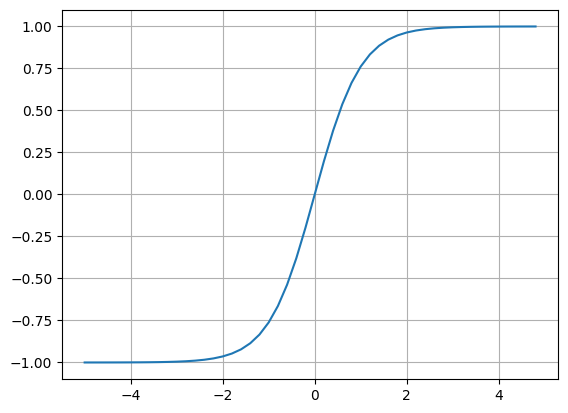

In [39]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

Notice how `tanh` compresses all inputs into the range $(-1,1)$. We can think
of values $>1$ as the neuron being active and values $<1$ as the neuron
being inactive.

Let's add a direct implementation of `tanh` into our `Value` object:



In [40]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def tanh(self):                                      # <--------------
        x = self.data                                    # <--------------
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)      # <--------------
        out = Value(t, (self, ), 'tanh')                 # <--------------
        return out                                       # <--------------

Now let's consider a 2-dimensional neuron with two inputs, two weights, a bias,
and let's see how it all gets applied:

This neuron embodies the following expression (refer to the figure of the neuron model a few chunks above):
\begin{align*}
o = \textnormal{tanh}\left( [(w_1 \cdot x_1) + (w_2 \cdot x_2)] + b \right )
\end{align*}



Let's choose a few values for the `x`'s, `w`'s, and `b`. The value of `b` may look 
a bit odd, but we've chosen a fine-tuned value for `b` so that the intermediate math
results in pretty values.

In [41]:
# inputs x1, x1
x1 = Value(2.0)
x2 = Value(0.0)
# weights w1, w2
w1 = Value(-3.0)
w2 = Value(1.0)
# bias of the neuron
b = Value(6.8813735870195432)

Now let's calculate the value of `o` by evaluating the expression (the "forward pass"
through the evaluation tree). Again, we're denoting certain *intermediate operations* 
(eg `x1*w1` as `x1w1`), just for clarity in the graph.

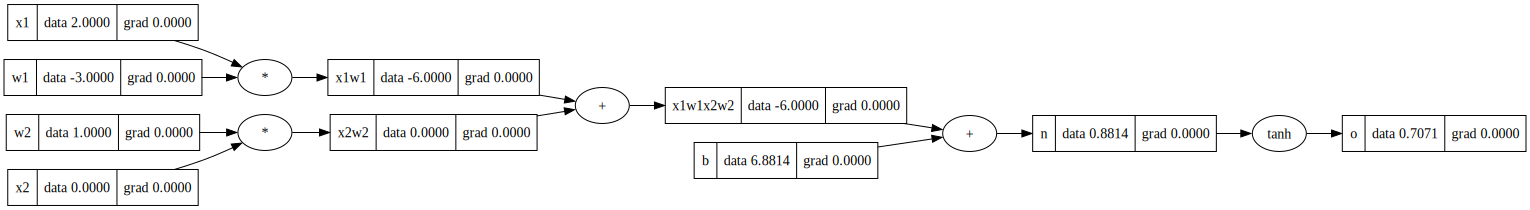

In [42]:
#  dot-product weighting that the neuron does among inputs
x1w1 = x1*w1
x2w2 = x2*w2

# the neuron function
x1w1x2w2 = x1w1+x2w2
# the neuron bias
n = x1w1x2w2 + b
# the neuron activation function
o = n.tanh()
draw_dot(o)

### Manual backpropagation



Let's manually fill out the derivatives for this computation graph.
We know that `o.grad = 1`

<details>
<summary>Spoiler: Think about this before viewing the answer!</summary>
</details>

In [43]:
o.grad = 1
# do/dn = 1 - tanh(n)**2 = 1 - o.data**2
n.grad = 0.5
# + operator 'distributes' the gradient
b.grad = 0.5
x1w1x2w2.grad = 0.5
# + operator 'distributes' the gradient
x1w1.grad = 0.5
x2w2.grad = 0.5
# * operator, take other value, multiply by parent grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

### Automatic backpropagation



Let's augment our `Value` object to add a function that performs the
backpropagation for us.



In [46]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None           # <--------------
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():                        # <--------------
            # apply chain rule for additive partial derivative
            self.grad += 1.0 * out.grad         # <--------------
            other.grad += 1.0 * out.grad        # <--------------
        out._backward = _backward               # <--------------
                                                # <--------------
        return out                              # <--------------

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():                         # <--------------
            # apply chain rule for multiplicative partial derivative
            self.grad += other.data * out.grad   # <--------------
            other.grad += self.data * out.grad   # <--------------
        out._backward = _backward                # <--------------
                                                 # <--------------
        return out                               # <--------------

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():                         # <--------------
            # apply derivative for tanh          # <--------------
            self.grad += (1 - t**2) * out.grad   # <--------------
        out._backward = _backward                # <--------------
                                                 # <--------------
        return out                               # <--------------

Now, let's try using our backprop capability with the `_backward()`, 
but first we need to re-initialize our neuron to ensure that all of 
the grads are zero.

In [47]:
# inputs x1, x1
x1 = Value(2.0)
x2 = Value(0.0)
# weights w1, w2
w1 = Value(-3.0)
w2 = Value(1.0)
# bias of the neuron
b = Value(6.8813735870195432)
# the dot-product weighting that the neuron does
x1w1 = x1*w1
x2w2 = x2*w2
# the neuron
x1w1x2w2 = x1w1+x2w2
n = x1w1x2w2 + b
o = n.tanh()
draw_dot(o)

Now, lets call `_backward()` at the root node.

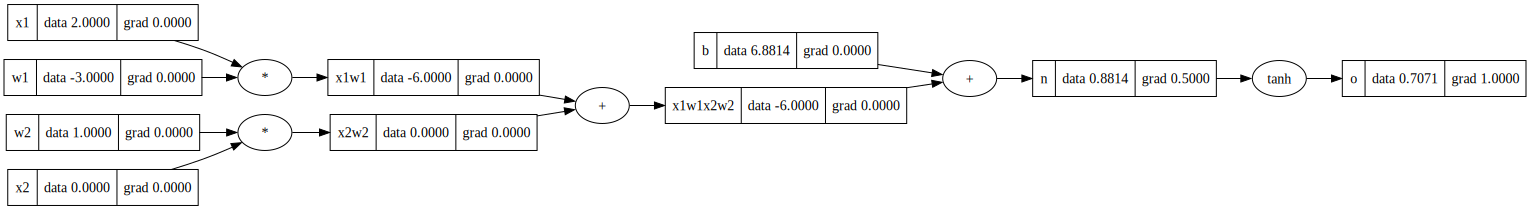

In [48]:
o.grad = 1.0
o._backward()

draw_dot(o)

This works for the first step! Now let's call `_backward()` for the other neurons:



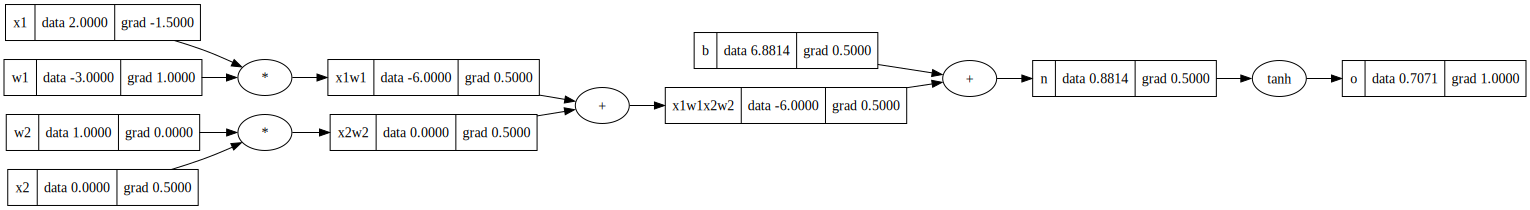

In [49]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

And, we have calculated the gradients up the computation chain.
But, wouldn't it be nice if we could have the program do this for us?
As in auto-backpropagation?

### Automatic backpropagation requires topological sorting



Note how we applied this backprop routine from right to left. How could we make
the program do that? We never want to call `._backward` before we "do everything
after it". So, this ordering of the graph can be achieved with this thing called
a *topological sort*, which is an ordering of a graph such that all of the edges
of the graph (the arrows) go in one direction (say, from left to right).

What follows is a way to perform topological sorting (fn:4). You can examine the
algorithm at your leisure.



In [50]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
print(topo)

[Value(data=6.881373587019543), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


Now let's build this capacity into a proper `backward()` function:



In [51]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # apply chain rule for additive partial derivative
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            # apply chain rule for multiplicative partial derivative
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # apply derivative for tanh
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):                           # <--------------

        # topological order all of the children in the graph
        topo = []                                 # <-------------- 
        visited = set()                           # <-------------- 
        def build_topo(v):                        # <-------------- 
            if v not in visited:                  # <-------------- 
                visited.add(v)                    # <-------------- 
                for child in v._prev:             # <-------------- 
                    build_topo(child)             # <-------------- 
                topo.append(v)                    # <-------------- 
        build_topo(self)                          # <-------------- 

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1                             # <-------------- 
        for v in reversed(topo):                  # <-------------- 
            v._backward()                         # <-------------- 

Now, let's re-define our neuron and apply our auto-backpropagation function.


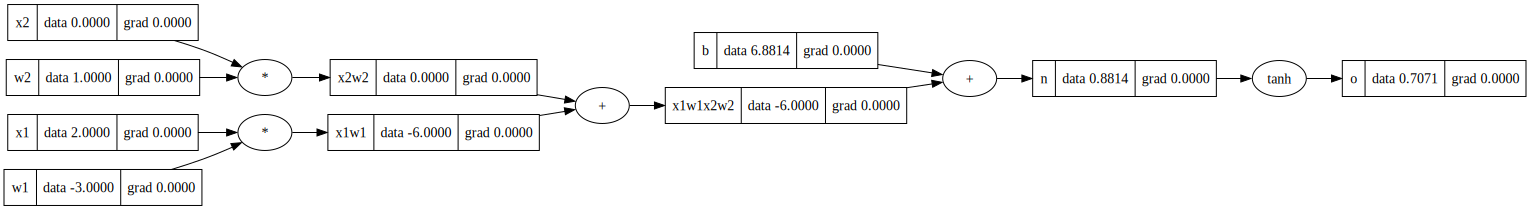

In [52]:
# inputs x1, x1
x1 = Value(2.0)
x2 = Value(0.0)
# weights w1, w2
w1 = Value(-3.0)
w2 = Value(1.0)
# bias of the neuron
b = Value(6.8813735870195432)
# the dot-product weighting that the neuron does
x1w1 = x1*w1
x2w2 = x2*w2
# the neuron
x1w1x2w2 = x1w1+x2w2
n = x1w1x2w2 + b
o = n.tanh()
draw_dot(o)

Okay, we've checked that all grads are zero. Now, lets call `o.backward()` and see the results.



In [53]:
o.backward()
draw_dot(o)

And that is backpropagation.

For one neuron.



## Footnotes



[fn:1] The only tricky thing is how the "op-nodes" are created. Take a deeper look at the code if you think that you will be using `graphviz` in the future.

[fn:2] aka, error function

[fn:3] Note that we're working in a function `lola, lolb, ...` so that if we mess with the values of `a,b,c,...`, they won't change for the rest of the program.

[fn:4] Specifically, a standard way to perform topological sorting on a directed-acyclic-graph. This works by starting at the root, and recursively performing depth-first-search at the child nodes. If you are a computer scientist (or data scientist) and you are not too familiar with these terms, it's worth looking up!